<a href="https://www.kaggle.com/code/habibulbasher01644/olive-leaf-image-classification?scriptVersionId=223050599" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/olive-leaf-image-dataset'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import all necessary library

In [74]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import collections 
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16, VGG19, MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input  # MobileNet V1 preprocessing
from tensorflow.keras.models import Model



# Approch:1 Custom CNN model without data augmentation

## 1. Define Dataset Paths

In [27]:
train_dir = '/kaggle/input/olive-leaf-image-dataset/dataset/train'
test_dir = '/kaggle/input/olive-leaf-image-dataset/dataset/test'
batch_size = 32
img_size = (224, 224)

## 2. Load Dataset Without Data Augmentation

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                          train_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical',
                          shuffle=True)
test_generator = test_datagen.flow_from_directory(
                          test_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical', 
                          shuffle=False)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.dataset summary

In [29]:
# Print dataset summary
print(f"Found {train_generator.samples} images belonging to {len(train_generator.class_indices)} classes in the training set.")
print(f"Found {test_generator.samples} images belonging to {len(test_generator.class_indices)} classes in the testing set.")
print(f"Class Labels: {train_generator.class_indices}")

# Function to count images per class
def count_images_per_class(directory, class_indices):
    class_counts = Counter()
    for class_name, class_index in class_indices.items():
        class_path = os.path.join(directory, class_name)
        class_counts[class_name] = len(os.listdir(class_path)) if os.path.exists(class_path) else 0
    return class_counts

# Get per-class image counts
train_class_counts = count_images_per_class(train_dir, train_generator.class_indices)
test_class_counts = count_images_per_class(test_dir, test_generator.class_indices)

# Print per-class distribution
print("\nTraining Data:")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nTesting Data:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

Found 2720 images belonging to 3 classes in the training set.
Found 680 images belonging to 3 classes in the testing set.
Class Labels: {'Healthy': 0, 'aculus_olearius': 1, 'olive_peacock_spot': 2}

Training Data:
Healthy: 830 images
aculus_olearius: 690 images
olive_peacock_spot: 1200 images

Testing Data:
Healthy: 220 images
aculus_olearius: 200 images
olive_peacock_spot: 260 images


## 4.Define Custom CNN Model

In [30]:
def build_custom_cnn():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Batch Normalization only in Block 1
    model.add(MaxPooling2D((2, 2)))

    # Block 2
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 3
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 4
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Block 5
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))  # Dropout to reduce overfitting
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    return model

custom_cnn_model = build_custom_cnn()
custom_cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 224, 224, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 224, 224, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1000)                │      12,545,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1000)                │       1,001,0

 Total params: 14,730,155 (56.19 MB)

 Trainable params: 14,730,123 (56.19 MB)

 Non-trainable params: 32 (128.00 B)

## 5.Train and Evaluate Model

In [31]:
optimizer = Adam(learning_rate=0.0001)

accuracy_history = []
loss_history = []
test_accuracy_history = []

def train_and_evaluate(model):
    print(f"🔹 Training Model using Adam optimizer...")

    # Compile Model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model
    history = model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=batch_size)

    # Store accuracy and loss values for each epoch
    accuracy_history.append(history.history['val_accuracy'])
    loss_history.append(history.history['val_loss'])

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    # Test Accuracy Calculation
    test_accuracy = np.sum(y_pred == y_true) / len(y_true)
    test_accuracy_history.append(test_accuracy)

    print(f"\n🔹 Classification Report for Adam:")
    print(classification_report(y_true, y_pred))

    print("\n🔹 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

    # Labels, title and ticks
    plt.title('Confusion Matrix for Model Evaluation')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    print(f"\n🔹 Test Accuracy for Adam: {test_accuracy:.4f}")

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Adam - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Adam - Loss')

    plt.show()


## 6.Train and evaluate with Adam optimizer

🔹 Training Model using Adam optimizer...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.5135 - loss: 0.9509 - val_accuracy: 0.5471 - val_loss: 1.0310
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.7490 - loss: 0.5900 - val_accuracy: 0.5868 - val_loss: 0.9631
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7927 - loss: 0.4979 - val_accuracy: 0.7000 - val_loss: 0.8505
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.8083 - loss: 0.4575 - val_accuracy: 0.6382 - val_loss: 0.7954
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8409 - loss: 0.3977 - val_accuracy: 0.6676 - val_loss: 0.7024
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.8620 - loss: 0.3515 - val_accuracy: 0.7132 - val_loss: 0.6622
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.8667 - loss: 0.3448 - val_accuracy: 0.7029 - val_loss: 0.6408
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.8831 - loss: 0.2744 - val_accuracy: 0.783

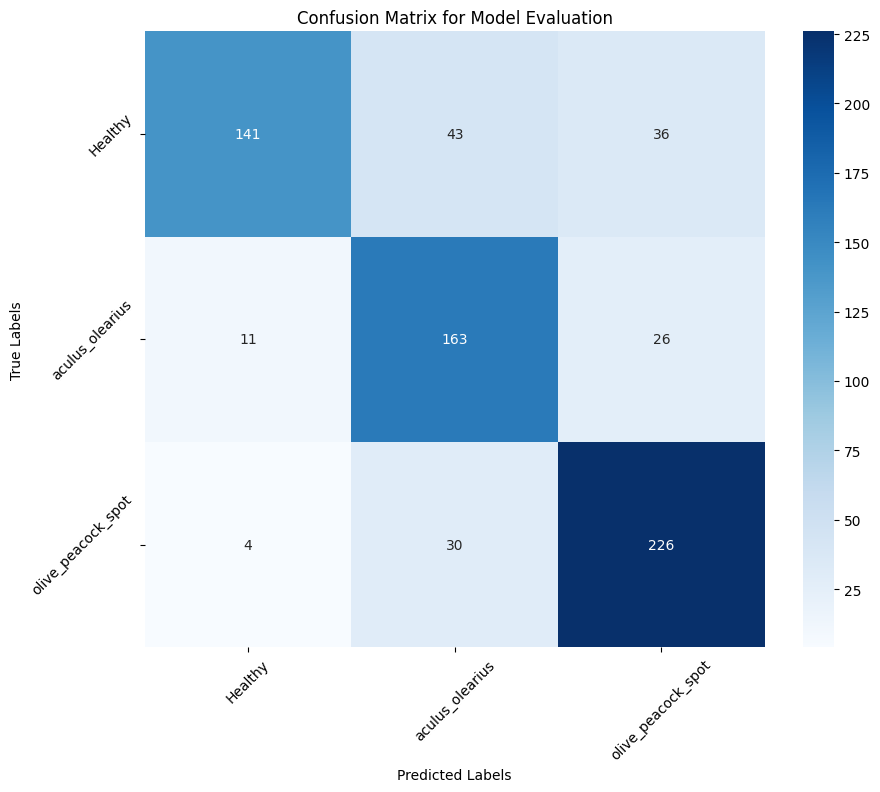

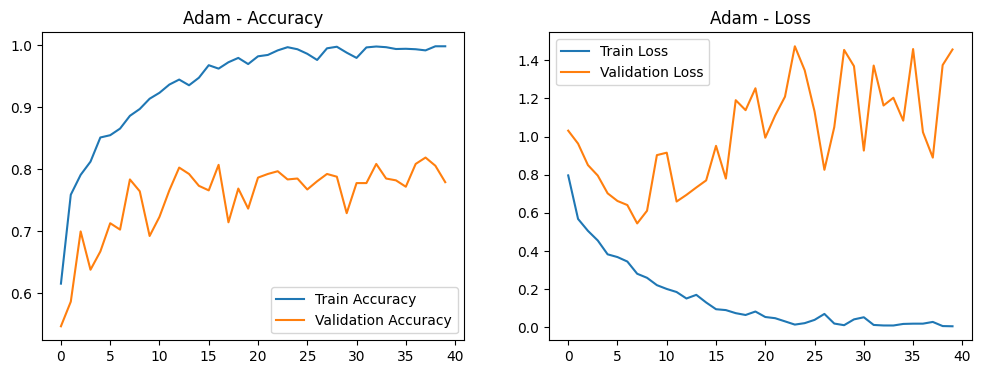

In [32]:
model = build_custom_cnn()

# Train and evaluate with Adam optimizer
train_and_evaluate(model)


# Approch:2 Custom CNN model with data augmentation

In [33]:
optimizer1 = Adam(learning_rate=0.0001)

# Create dictionaries to store accuracy, loss, and test accuracy values for Adam optimizer
accuracy_history1 = []
loss_history1 = []
test_accuracy_history1 = []

## 1.Data Augmentation

In [34]:
train_datagen1 = ImageDataGenerator(
    rescale=1./255,  # Rescale image pixel values to [0, 1]
    rotation_range=30,  # Random rotations between -30 to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range= 0.4, # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

test_datagen1= ImageDataGenerator(rescale=1./255)


## 2.Load Dataset With Data Augmentation

In [35]:
train_generator1= train_datagen1.flow_from_directory(
                          train_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical',
                          shuffle=True)
test_generator1= test_datagen1.flow_from_directory(
                          test_dir, 
                          target_size=img_size, 
                          batch_size=batch_size, 
                          class_mode='categorical', 
                          shuffle=False)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 2.Train and Evaluating Model

In [36]:
def train_and_evaluate_with_augmentation(model):
    print(f"🔹 Training Model using Adam optimizer with Data Augmentation...")

    # Compile Model
    model.compile(optimizer=optimizer1, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train Model with augmented data
    history1 = model.fit(
        train_generator1,  # Augmented training data
        validation_data=test_generator1,  # Validation data
        epochs=40
    )

    # Store accuracy and loss values for each epoch
    accuracy_history1.append(history1.history['val_accuracy'])
    loss_history1.append(history1.history['val_loss'])

    # Evaluate Model
    y_pred = np.argmax(model.predict(test_generator1), axis=1)
    y_true = test_generator1.classes

    cm = confusion_matrix(y_true, y_pred)
    # Test Accuracy Calculation
    test_accuracy1 = np.sum(y_pred == y_true) / len(y_true)
    test_accuracy_history1.append(test_accuracy1)

    print(f"\n🔹 Classification Report for Adam with Data Augmentation:")
    print(classification_report(y_true, y_pred))

    print("\n🔹 Confusion Matrix:")
    print(cm)
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator1.class_indices.keys(), yticklabels=test_generator1.class_indices.keys())

    # Labels, title and ticks
    plt.title('Confusion Matrix for Model Evaluation')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    print(f"\n🔹 Test Accuracy for Adam with Data Augmentation: {test_accuracy1:.4f}")

    # Plot Accuracy and Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Adam with Data Augmentation - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Adam with Data Augmentation - Loss')

    plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🔹 Training Model using Adam optimizer with Data Augmentation...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 42s 394ms/step - accuracy: 0.4645 - loss: 1.0295 - val_accuracy: 0.4044 - val_loss: 1.0778
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 381ms/step - accuracy: 0.6314 - loss: 0.7270 - val_accuracy: 0.5500 - val_loss: 1.0252
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.6930 - loss: 0.6453 - val_accuracy: 0.5044 - val_loss: 0.9590
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 384ms/step - accuracy: 0.7432 - loss: 0.5727 - val_accuracy: 0.3897 - val_loss: 1.0205
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 385ms/step - accuracy: 0.7591 - loss: 0.5586 - val_accuracy: 0.5338 - val_loss: 0.8401
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.7710 - loss: 0.5337 - val_accuracy: 0.5632 - val_loss: 1.0134
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 382ms/step - accuracy: 0.7683 - loss: 0.5480 - val_accuracy: 0.6132 - val_loss: 0.7720
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 387ms/step - accuracy: 0.8091 - loss: 0.4514 - val_accuracy: 0.692

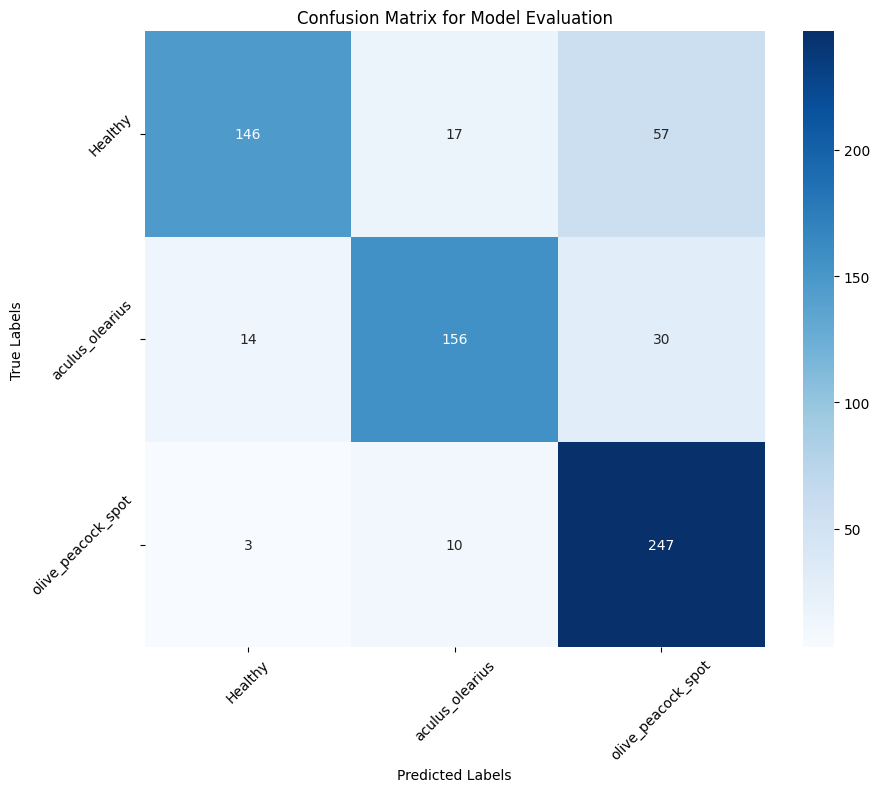

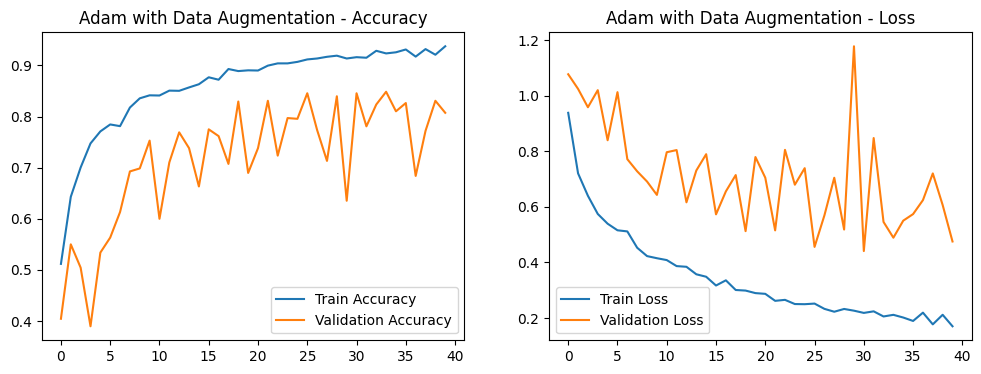

In [37]:

# Build the custom CNN model (make sure to define your model here)
model = build_custom_cnn()

# Train and evaluate with Adam optimizer and data augmentation
train_and_evaluate_with_augmentation(model)


# Approach 3: Without data augmentation Using 3 Pre-trained CNN Model. 
### VGG16,VGG19 and MobileNet

## 1. Function to build model (VGG16, VGG19, MobileNetV3)


In [59]:
def build_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False  # Freeze convolutional layers
    
    x = Flatten()(base_model.output)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation="softmax")(x)  # 3-class classification
    
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [78]:

# Load Pre-trained Models
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [80]:

# Build Models
vgg16_model = build_model(vgg16_base)
vgg19_model = build_model(vgg19_base)
mobilenet_model = build_model(mobilenet_base)

## 2.Data Preprocessing (No Augmentation, Only Rescaling)

In [81]:

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',  # Replace with dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',  # Replace with dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.Train models

In [63]:

# Train Models
print("🔹 Training VGG16 Model...")
history_vgg16 = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)

print("🔹 Training VGG19 Model...")
history_vgg19 = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)


🔹 Training VGG16 Model...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step - accuracy: 0.5168 - loss: 1.1274 - val_accuracy: 0.6838 - val_loss: 0.7052
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.7899 - loss: 0.5217 - val_accuracy: 0.6882 - val_loss: 0.6827
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.8209 - loss: 0.4572 - val_accuracy: 0.7838 - val_loss: 0.5301
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.8726 - loss: 0.3473 - val_accuracy: 0.8029 - val_loss: 0.4779
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.8553 - loss: 0.3651 - val_accuracy: 0.7868 - val_loss: 0.5628
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.8677 - loss: 0.3055 - val_accuracy: 0.8088 - val_loss: 0.4430
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.9139 - loss: 0.2409 - val_accuracy: 0.8074 - val_loss: 0.4666
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.9129 - loss: 0.2422 - val_accuracy: 0.823

In [82]:
print("🔹 Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)

🔹 Training MobileNetV3 Model...
Epoch 1/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.7013 - loss: 2.0308 - val_accuracy: 0.8809 - val_loss: 0.3946
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9226 - loss: 0.2822 - val_accuracy: 0.8647 - val_loss: 0.4451
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.9608 - loss: 0.1147 - val_accuracy: 0.8868 - val_loss: 0.3582
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.9765 - loss: 0.0709 - val_accuracy: 0.8824 - val_loss: 0.4425
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9843 - loss: 0.0471 - val_accuracy: 0.8912 - val_loss: 0.3898
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9799 - loss: 0.0482 - val_accuracy: 0.8971 - val_loss: 0.4218
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.9812 - loss: 0.0462 - val_accuracy: 0.8662 - val_loss: 0.6192
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 

## 4.Evaluate models

In [83]:

# Evaluate Models
def evaluate_model(model, test_generator, model_name):
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n🔹 {model_name} Test Accuracy: {test_acc:.4f}")
    
    print(f"\n🔹 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))

    print(f"\n🔹 Confusion Matrix for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.3441 - loss: 1.0707

🔹 VGG16 Test Accuracy: 0.2765

🔹 Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.33      0.35      0.34       220
           1       0.23      0.38      0.28       200
           2       0.30      0.14      0.19       260

    accuracy                           0.28       680
   macro avg       0.29      0.29      0.27       680
weighted avg       0.29      0.28      0.27       680


🔹 Confusion Matrix for VGG16:
[[ 76 108  36]
 [ 75  75  50]
 [ 76 147  37]]


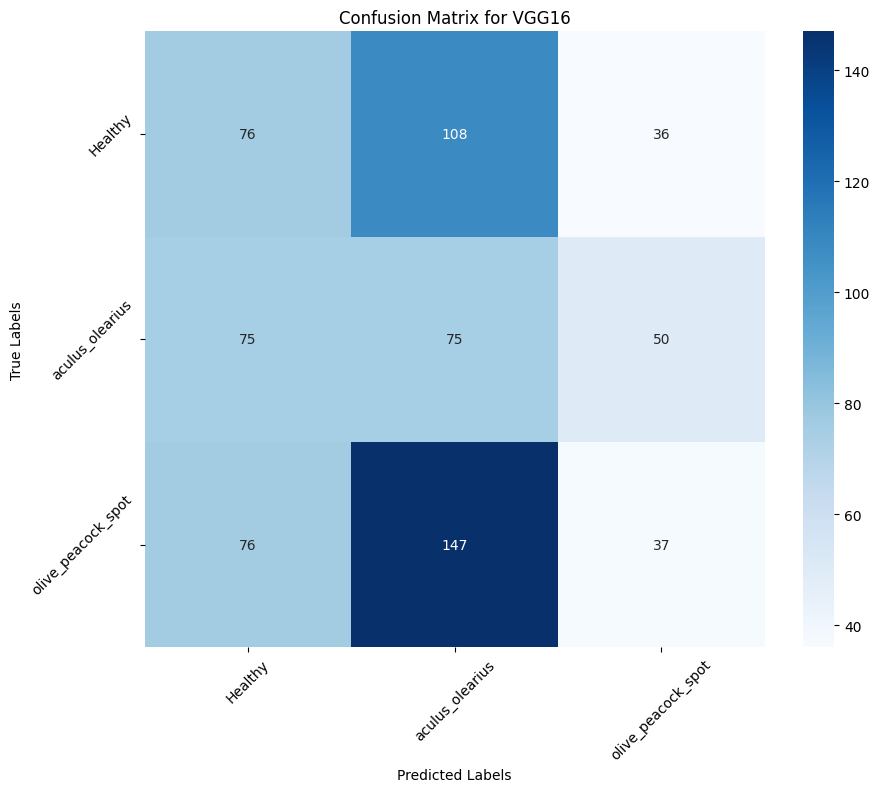

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.1156 - loss: 1.4417

🔹 VGG19 Test Accuracy: 0.3824

🔹 Classification Report for VGG19:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       220
           1       0.00      0.00      0.00       200
           2       0.38      1.00      0.55       260

    accuracy                           0.38       680
   macro avg       0.13      0.33      0.18       680
weighted avg       0.15      0.38      0.21       680


🔹 Confusion Matrix for VGG19:
[[  0   0 220]
 [  0   0 200]
 [  0   0 260]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


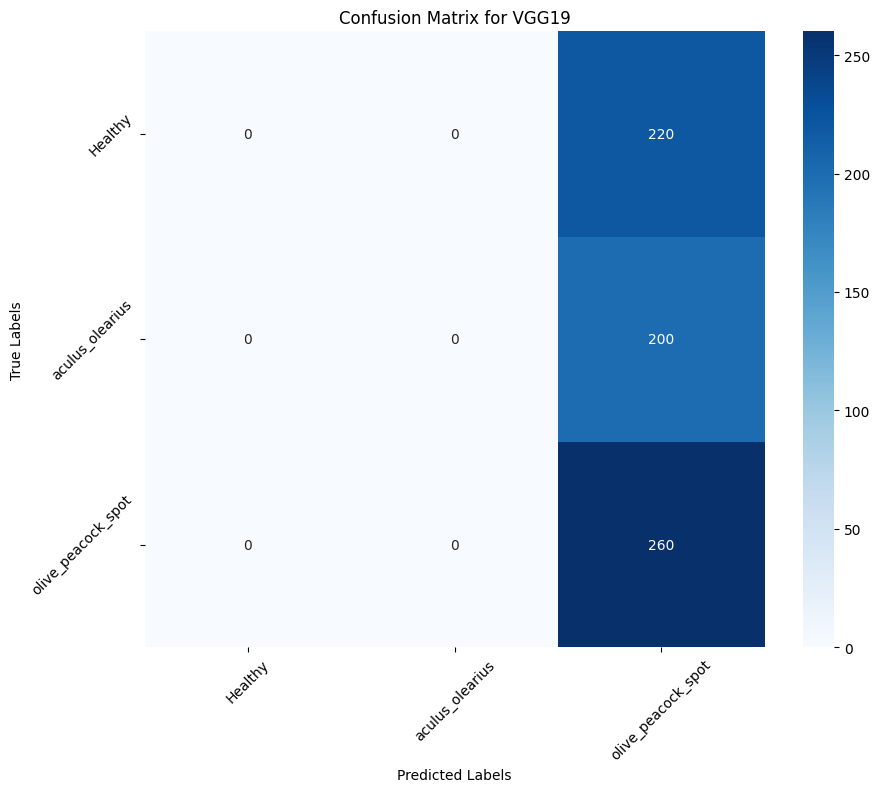

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8658 - loss: 1.4304 

🔹 MobileNet Test Accuracy: 0.8676

🔹 Classification Report for MobileNet:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87       220
           1       0.91      0.83      0.87       200
           2       0.80      0.93      0.86       260

    accuracy                           0.87       680
   macro avg       0.88      0.86      0.87       680
weighted avg       0.87      0.87      0.87       680


🔹 Confusion Matrix for MobileNet:
[[182   6  32]
 [  6 167  27]
 [  8  11 241]]


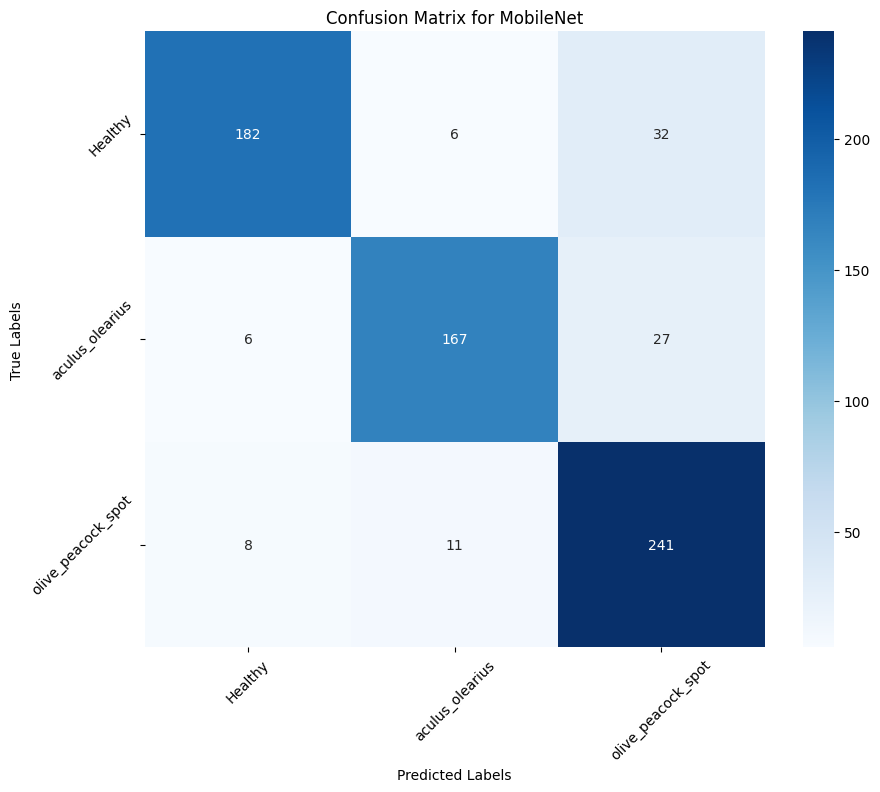

In [84]:

# Evaluate VGG16, VGG19, MobileNetV3
evaluate_model(vgg16_model, test_generator, "VGG16")
evaluate_model(vgg19_model, test_generator, "VGG19")
evaluate_model(mobilenet_model, test_generator, "MobileNet")

## 5.Plot Accuracy & Loss

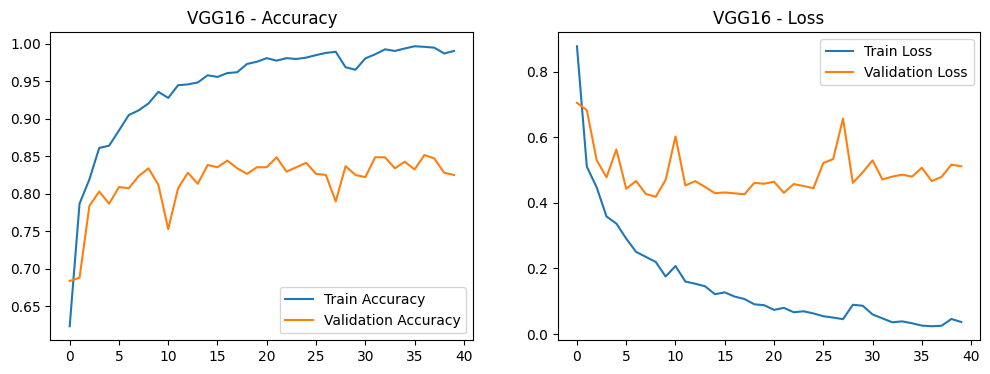

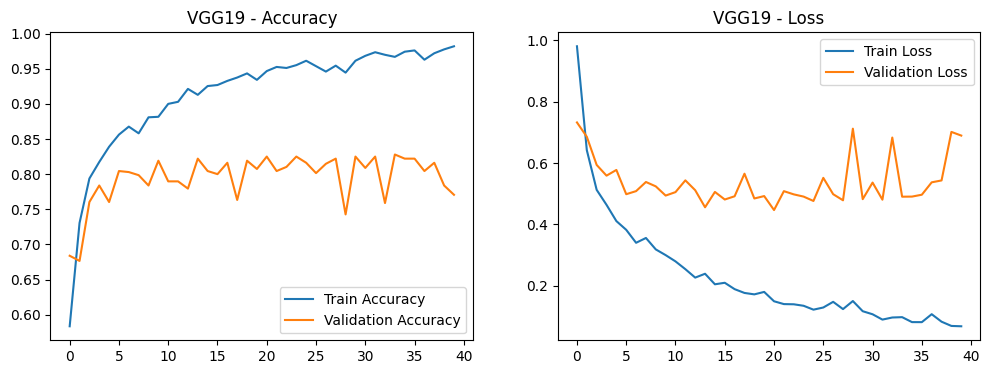

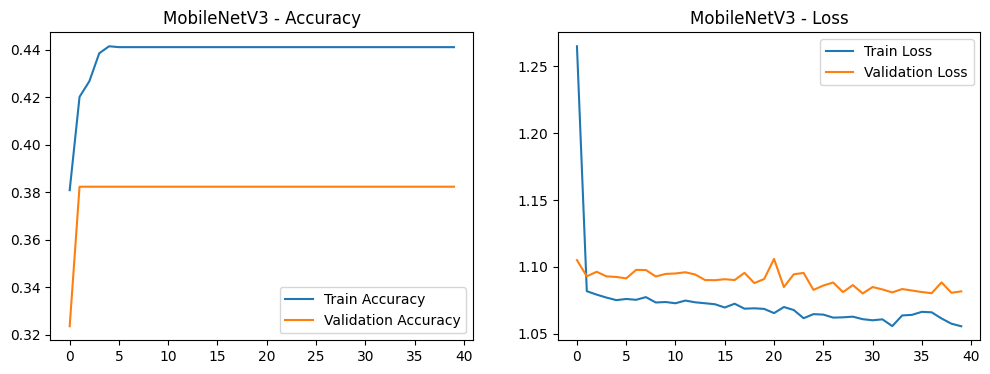

In [67]:

def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()

# Plot for all models
plot_results(history_vgg16, "VGG16")
plot_results(history_vgg19, "VGG19")
plot_results(history_mobilenet, "MobileNetV3")

# Data Augmentation
## ImageDataGenerator
    
* rescale: Makes the image numbers smaller so the computer can understand.(rescale=1./255 - Makes all pixel values between 0 and 1)
* rotation_range: Spins the image around.
* width_shift_range and height_shift_range: Moves the image left/right or up/down.
* shear_range: Tilts the image.
* zoom_range: Zooms in or out.
* horizontal_flip and vertical_flip: Flips the image left/right or upside-down.
* fill_mode: Fills empty spaces when you move or tilt the image.


# Approach 4: With data augmentation Using 3 Pre-trained CNN Model.¶ 
### VGG16,VGG19 and MobileNet 

## 1. The model building function

In [70]:

# Define the model building function
def build_model(base_model):
    # Freeze the convolutional base layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom fully connected layers
    x = Flatten()(base_model.output)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation="softmax")(x)  # For 3-class classification
    
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model




## 2.Data Preprocessing (With Augmentation)

In [71]:
# Load Pre-trained Models
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Build Models
vgg16_model = build_model(vgg16_base)
vgg19_model = build_model(vgg19_base)
mobilenet_model = build_model(mobilenet_base)

# Define Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare Data Generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',  # Update with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',  # Update with your dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2720 images belonging to 3 classes.
Found 680 images belonging to 3 classes.


## 3.Train Models

In [72]:

# Train Models
print("🔹 Training VGG16 Model...")
history_vgg16 = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)

print("🔹 Training VGG19 Model...")
history_vgg19 = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)
print("🔹 Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=test_generator, epochs=40, batch_size=32)


🔹 Training VGG16 Model...
Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 404ms/step - accuracy: 0.5190 - loss: 1.1374 - val_accuracy: 0.6735 - val_loss: 0.7655
Epoch 2/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.6986 - loss: 0.7128 - val_accuracy: 0.7132 - val_loss: 0.6509
Epoch 3/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.7467 - loss: 0.6080 - val_accuracy: 0.7338 - val_loss: 0.6165
Epoch 4/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 35s 384ms/step - accuracy: 0.7716 - loss: 0.5416 - val_accuracy: 0.6941 - val_loss: 0.7000
Epoch 5/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 394ms/step - accuracy: 0.7711 - loss: 0.5555 - val_accuracy: 0.7529 - val_loss: 0.5741
Epoch 6/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.7871 - loss: 0.5005 - val_accuracy: 0.7500 - val_loss: 0.6180
Epoch 7/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.8027 - loss: 0.4972 - val_accuracy: 0.7412 - val_loss: 0.5841
Epoch 8/40
85/85 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.8091 - loss: 0.4582 - val_accuracy: 0.779

## 4.Evaluate models

In [ ]:

# Evaluate Models and Plot Confusion Matrix
def evaluate_model(model, test_generator, model_name):
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n🔹 {model_name} Test Accuracy: {test_acc:.4f}")
    
    print(f"\n🔹 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))

    print(f"\n🔹 Confusion Matrix for {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# Evaluate VGG16, VGG19, MobileNetV3
evaluate_model(vgg16_model, test_generator, "VGG16")
evaluate_model(vgg19_model, test_generator, "VGG19")
evaluate_model(mobilenet_model, test_generator, "MobileNet")


## 5.Plotting Accuracy and Loss for all models


In [ ]:

def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.show()

# Plot for all models
plot_results(history_vgg16, "VGG16")
plot_results(history_vgg19, "VGG19")
plot_results(history_mobilenet, "MobileNet")

# Approach 5: Model Fine-Tune with data augmentation Using 3 Pre-trained CNN Model.
### VGG16,VGG19 and MobileNet

## 1.Build Model Function with Fine-Tuning 


In [ ]:
def build_model(base_model, unfreeze_from=30):
    """
    Freeze layers before 'unfreeze_from' index and unfreeze layers from that index onward.
    Add custom classification layers on top.
    """
    for i, layer in enumerate(base_model.layers):
        if i < unfreeze_from:
            layer.trainable = False
        else:
            layer.trainable = True
    
    x = Flatten()(base_model.output)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation="softmax")(x)  # 3-class classification
    
    model = Model(inputs=base_model.input, outputs=x)
    # Use a low learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

## 2.Load Pre-trained Base Models

In [ ]:
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg19_base = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_base = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

## 3.Build Final Models (Fine-Tuning: unfreeze layers from index 30)


In [ ]:
vgg16_model = build_model(vgg16_base, unfreeze_from=30)
vgg19_model = build_model(vgg19_base, unfreeze_from=30)
mobilenet_model = build_model(mobilenet_base, unfreeze_from=30)

## 4.Data Augmentation


In [ ]:
# For MobileNet (V1), we use its preprocess_input for proper scaling.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## 5.Create Data Generators ---


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/train',  # Update with your train dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/olive-leaf-image-dataset/dataset/test',   # Update with your test dataset path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

## 6.Train the Models

In [ ]:
print("🔹 Training VGG16 Model...")
history_vgg16 = vgg16_model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=32)

print("🔹 Training VGG19 Model...")
history_vgg19 = vgg19_model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=32)

print("🔹 Training MobileNet Model...")
history_mobilenet = mobilenet_model.fit(train_generator, validation_data=test_generator, epochs=20, batch_size=32)


## 7.Evaluation Function


In [ ]:
def evaluate_model(model, test_generator, model_name):
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    y_true = test_generator.classes
    
    test_loss, test_acc = model.evaluate(test_generator)
    print(f"\n🔹 {model_name} Test Accuracy: {test_acc:.4f}")
    
    print(f"\n🔹 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n🔹 Confusion Matrix for {model_name}:")
    print(cm)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

# --- Evaluate Each Model ---
evaluate_model(vgg16_model, test_generator, "VGG16")
evaluate_model(vgg19_model, test_generator, "VGG19")
evaluate_model(mobilenet_model, test_generator, "MobileNet")



## 8.Plot Training History


In [ ]:

def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')
    plt.show()

plot_results(history_vgg16, "VGG16")
plot_results(history_vgg19, "VGG19")
plot_results(history_mobilenet, "MobileNet")